# Cats Feature Points Estimation
Predicting cats feature points using a feature pyramid network.

Loading dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, BatchNormalization, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
import cv2
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, MobileNetV2

Loading dataset from kaggle

In [2]:
!kaggle datasets download -d crawford/cat-dataset

Dataset URL: https://www.kaggle.com/datasets/crawford/cat-dataset
License(s): CC0-1.0
100% 4.04G/4.04G [03:35<00:00, 18.0MB/s]
100% 4.04G/4.04G [03:35<00:00, 20.1MB/s]


In [3]:
%%capture
!unzip cat-dataset.zip

## Understanding Data

Each record contains an image and a file with 19 values.

The first value represents the number of points (which is 9)

Each two next values represent a coordinate in the picture which shows a feature point ranging:
* Left Eye
* Right Eye
* Mouth
* Left Ear 1
* Left Ear 2
* Left Ear 3
* Right Ear 1
* Right Ear 2
* Right Ear 3

One sample

In [ ]:
path = 'CAT_00/00000001_000.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
annot_path = path + '.cat'
with open(annot_path,'r') as f:
    coordinates = f.readline()
    coordinates = str(coordinates).split(' ')[:-1]
len(list(map(int, coordinates)))

19

In [ ]:
annots = list(map(int, coordinates))[1:]

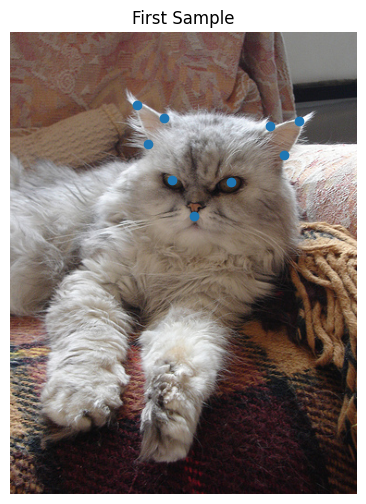

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title('First Sample')
plt.axis('off')
plt.scatter(annots[0:18:2], annots[1:18:2])
plt.show()

**How to scale and normalize**

In [ ]:
path = 'CAT_00/00000001_000.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
w, h = img.shape[:2]

Scaling

In [ ]:
target_size = (224, 224)
resized_image = cv2.resize(img, target_size)

In [ ]:
scale_x = target_size[1] / h
scale_y = target_size[0] / w

In [ ]:
annot_path = path + '.cat'
with open(annot_path,'r') as f:
    coordinates = f.readline()
    coordinates = str(coordinates).split(' ')[:-1]
annots = list(map(int, coordinates))[1:]

In [ ]:
annots[0:18:2] = list(np.array(annots[0:18:2]) * scale_x)
annots[1:18:2] = list(np.array(annots[1:18:2]) * scale_y)

Normalizing

In [ ]:
resized_image = resized_image / 255.0

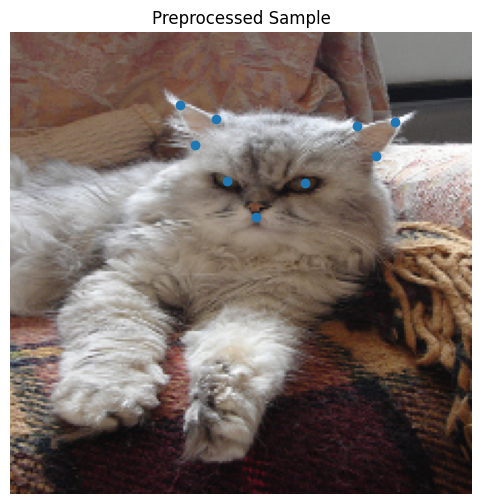

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(resized_image)
plt.title('Preprocessed Sample')
plt.axis('off')
plt.scatter(annots[0:18:2], annots[1:18:2])
plt.show()

## Preprocessing and Preparing Data

Setting hyperparameters

In [2]:
set_numbers = 1
limit = 2000
target_size = (224, 224)

In [3]:
def load_annots(path):
    path = path + '.cat'
    with open(path, 'r') as f:
        coordinates = f.readline()
        coordinates = str(coordinates).split(' ')[:-1]
    return list(map(int, coordinates))

In [4]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    annots = load_annots(path)[1:]
    w, h = img.shape[:2]
    return img, annots , w , h

In [5]:
def preprocess_image(image):
    resized_image = cv2.resize(image, target_size)
    return resized_image / 255.0

In [6]:
def preprocess_annots(annots, w, h):
    scale_x = target_size[1] / h
    scale_y = target_size[0] / w
    annots[0:18:2] = list(np.array(annots[0:18:2]) * scale_x)
    annots[1:18:2] = list(np.array(annots[1:18:2]) * scale_y)
    return annots

In [7]:
def load_dataset(path):
    root = path
    images = []
    annots = []
    counter = 0
    for root, _, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg') and counter < limit:
                image, annot, w, h = load_image(os.path.join(root, file))
                image = preprocess_image(image)
                annot = preprocess_annots(annot, w, h)
                images.append(image)
                annots.append(annot)
                counter += 1
    images = np.asarray(images)
    annots = np.asarray(annots)
    return images, annots.reshape(-1, 18)

In [8]:
X, y = np.empty((0, 224, 224, 3)), np.empty((0, 18))

Only one folder can be loaded due to colab's limitations

In [9]:
for i in range(set_numbers):
    path = 'CAT_0' + str(i)
    images, annots = load_dataset(path)
    X = np.vstack((X, images))
    y = np.vstack((y, annots))

In [10]:
X.shape, y.shape

((1706, 224, 224, 3), (1706, 18))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
del X
del y

---
## Modeling

We reduce image size to 224 * 224.


Also, after some tests, it was evident that MobileNet was more suitable for this task and achieved better results.

Backbone

In [13]:
input_shape = (224, 224, 3)
backbone = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

In [14]:
c2_output = backbone.get_layer('block_3_expand_relu').output  # 28x28
c3_output = backbone.get_layer('block_6_expand_relu').output  # 14x14
c4_output = backbone.get_layer('block_13_expand_relu').output  # 7x7
c5_output = backbone.get_layer('block_16_project').output  # 7x7

FPN

In [15]:
def build_fpn(c2, c3, c4, c5):
    p5 = Conv2D(128, (1, 1), padding='same')(c5)
    p4 = add([UpSampling2D(size=(2, 2))(p5), Conv2D(128, (1, 1), padding='same')(c4)])
    p3 = add([UpSampling2D(size=(2, 2))(p4), Conv2D(128, (1, 1), padding='same')(c3)])
    p2 = add([UpSampling2D(size=(2, 2))(p3), Conv2D(128, (1, 1), padding='same')(c2)])
    p3_upsampled = UpSampling2D(size=(2, 2))(p3)
    p4_upsampled = UpSampling2D(size=(4, 4))(p4)
    p5_upsampled = UpSampling2D(size=(8, 8))(p5)
    return p2, p3_upsampled, p4_upsampled, p5_upsampled

Detection head

In [16]:
def build_detection_head(inputs):
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(18, activation='linear')(x)
    return x

Building the model

In [17]:
inputs = Input(shape=input_shape)
backbone_model = Model(inputs=backbone.input, outputs=[c2_output, c3_output, c4_output, c5_output])
c2, c3, c4, c5 = backbone_model(inputs)
p2, p3_upsampled, p4_upsampled, p5_upsampled = build_fpn(c2, c3, c4, c5)
fpn_output = Concatenate()([p2, p3_upsampled, p4_upsampled, p5_upsampled])
outputs = build_detection_head(fpn_output)
model = Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 56, 56, 144),        1841984   ['input_2[0][0]']             
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 576),                                                
                              (None, 7, 7, 320)]                                                  
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 128)            41088     ['model[0][3]']         

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
48/48 [==============================] - 62s 410ms/step - loss: 10372.1934 - mae: 92.7607 - val_loss: 15274.0791 - val_mae: 115.3707
Epoch 2/30
48/48 [==============================] - 11s 234ms/step - loss: 10058.9912 - mae: 92.1092 - val_loss: 12362.9971 - val_mae: 104.7035
Epoch 3/30
48/48 [==============================] - 10s 213ms/step - loss: 9644.0547 - mae: 90.6688 - val_loss: 12290.3789 - val_mae: 102.8625
Epoch 4/30
48/48 [==============================] - 11s 229ms/step - loss: 9090.4434 - mae: 88.1461 - val_loss: 9896.0479 - val_mae: 89.8394
Epoch 5/30
48/48 [==============================] - 11s 219ms/step - loss: 8356.5479 - mae: 84.3445 - val_loss: 8816.0859 - val_mae: 84.4424
Epoch 6/30
48/48 [==============================] - 11s 221ms/step - loss: 7427.6475 - mae: 79.1099 - val_loss: 9280.9365 - val_mae: 86.1406
Epoch 7/30
48/48 [==============================] - 11s 222ms/step - loss: 6380.9956 - mae: 72.6171 - val_loss: 4410.1284 - val_mae: 57.1682
Epoch

## Evaluation

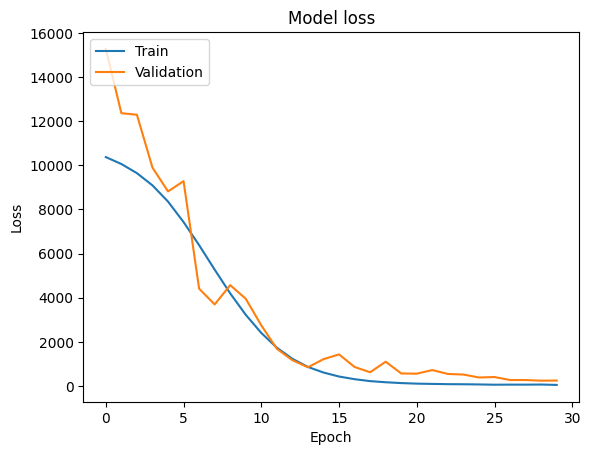

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

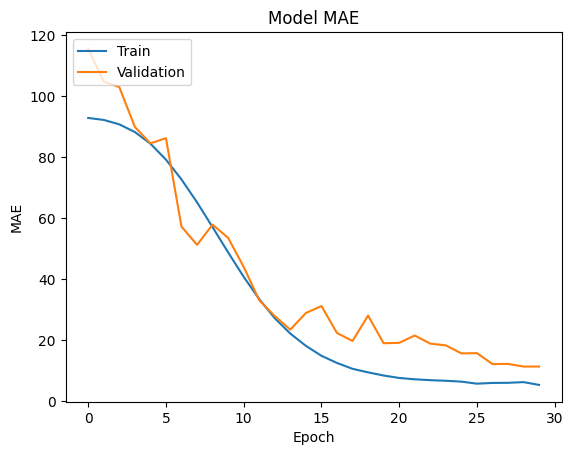

In [22]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Prediction

1/1 [==============================] - 3s 3s/step


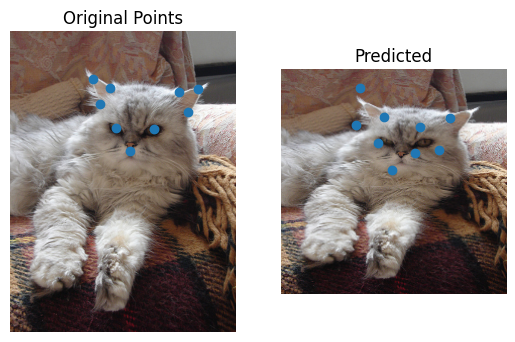

In [23]:
img, l, w, h = load_image('CAT_00/00000001_000.jpg')

figure = plt.subplot(1, 2, 1)
figure.set_title('Original Points')
plt.axis('off')
plt.imshow(img)
plt.scatter(l[0:18:2], l[1:18:2])

image = preprocess_image(img)
y = model.predict(np.expand_dims(image,axis=0)).flatten()
figure = plt.subplot(1, 2, 2)
figure.set_title('Predicted')
plt.axis('off')
plt.imshow(image)
plt.scatter(y[0:18:2], y[1:18:2])
plt.show()